# Ticket Resolution Workflow Efficiency Analysis

This project analyzes the efficiency of a multi-stage ticket resolution workflow, similar to a technical support or customer help desk system. The goal is to identify bottlenecks, delays, and resolution outcomes that impact operational performance.


## Workflow Overview

This mock data I created represents a simplified ticket resolution workflow, like one found in a tech support desk (or, more broadly, any sort of operational intake system). Tickets move through the following stages:

1. **Received** – Ticket enters the system through an intake channel
2. **Validated** – Initial checks ensure required information is present
3. **Reviewed** – A human operator reviews the ticket and determines next steps
4. **Resolved** – Ticket is successfully completed or escalated

Not all tickets progress through every stage. Drop-offs, delays, and escalations are expected, so I intentionally created these in my mock data to reflect real-world operational constraints. Below the code displays the first 5 rows of my generated dataset of 500 tickets.


In [45]:
import numpy as np
import pandas as pd

np.random.seed(42)

num_tickets = 500

TicketIds = range(1, num_tickets + 1)
Sources = np.random.choice(
    ['Email', 'WebForm', 'Chat', 'API'],
    size=num_tickets,
    p=[0.35, 0.30, 0.25, 0.10]
)

ReceivedDates = pd.to_datetime('2024-01-01') + pd.to_timedelta(
    np.random.randint(0, 60, size=num_tickets), unit='D'
)

ValidatedDates = []
ReviewedDates = []
ResolvedDates = []
Outcomes = []

for received in ReceivedDates:
    # Validation stage
    if np.random.rand() < 0.95:
        validated = received + pd.to_timedelta(np.random.randint(0, 2), unit='D')
    else:
        validated = pd.NaT
    
    # Review stage
    if pd.notna(validated) and np.random.rand() < 0.90:
        reviewed = validated + pd.to_timedelta(np.random.randint(1, 5), unit='D')
    else:
        reviewed = pd.NaT
    
    # Resolution stage
    if pd.notna(reviewed):
        if np.random.rand() < 0.80:
            resolved = reviewed + pd.to_timedelta(np.random.randint(1, 7), unit='D')
            outcome = 'Resolved'
        else:
            resolved = pd.NaT
            outcome = 'Escalated'
    else:
        resolved = pd.NaT
        outcome = 'Dropped'
    
    ValidatedDates.append(validated)
    ReviewedDates.append(reviewed)
    ResolvedDates.append(resolved)
    Outcomes.append(outcome)

tickets = pd.DataFrame({
    'TicketId': TicketIds,
    'Source': Sources,
    'ReceivedDate': ReceivedDates,
    'ValidatedDate': ValidatedDates,
    'ReviewedDate': ReviewedDates,
    'ResolvedDate': ResolvedDates,
    'Outcome': Outcomes
})

tickets.head()


,TicketId,Source,ReceivedDate,ValidatedDate,ReviewedDate,ResolvedDate,Outcome
0,1,WebForm,2024-02-23,2024-02-24,2024-02-27,2024-03-03,Resolved
1,2,API,2024-01-17,2024-01-18,2024-01-22,2024-01-26,Resolved
2,3,Chat,2024-01-09,2024-01-10,2024-01-13,2024-01-17,Resolved
3,4,WebForm,2024-02-02,2024-02-02,2024-02-05,NaT,Escalated
4,5,Email,2024-02-22,2024-02-23,2024-02-26,2024-02-29,Resolved


## Stage Completion Analysis

To understand where inefficiencies may exist, the first step is to measure how many tickets successfully progress through each stage of the workflow.

This analysis helps identify:
- Where tickets are most likely to drop off
- Which stages may require additional tooling or process improvements

Raw counts provide useful context, but completion *rates* allow for easier comparison. Below I create/display a table of the completion rates for each stage of the workflow, so I can compare each step relative to the others.


In [46]:
stage_completion = {
    'Received': len(tickets),
    'Validated': tickets['ValidatedDate'].notna().sum(),
    'Reviewed': tickets['ReviewedDate'].notna().sum(),
    'Resolved': tickets['ResolvedDate'].notna().sum()
}

completion_df = pd.DataFrame.from_dict(
    stage_completion,
    orient='index',
    columns=['TicketCount']
).reset_index().rename(columns={'index': 'Stage'})

completion_df['CompletionRate'] = (
    completion_df['TicketCount'] / completion_df.loc[completion_df['Stage'] == 'Received', 'TicketCount'].values[0]
)

completion_df


,Stage,TicketCount,CompletionRate
0,Received,500,1.000
1,Validated,479,0.958
2,Reviewed,439,0.878
3,Resolved,350,0.700


## Visualizing Workflow Drop-Off

I created a visual representation of these completion rates in order to more easily identify bottlenecks at a glance. This view is particularly useful for stakeholders/non-technical people who need to quickly understand operational performance without digging into raw numbers.


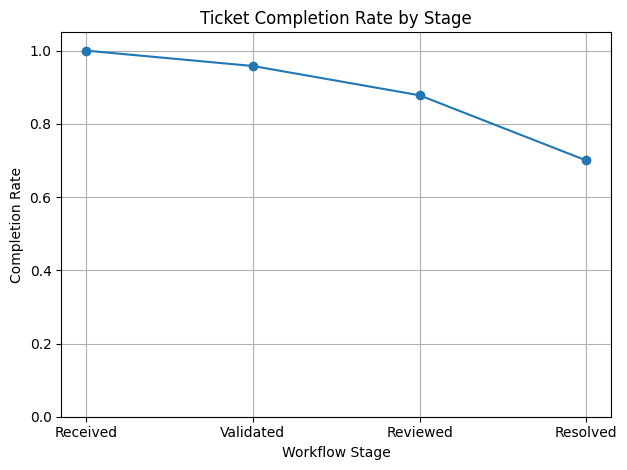

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(completion_df['Stage'], completion_df['CompletionRate'], marker='o')
plt.xlabel('Workflow Stage')
plt.ylabel('Completion Rate')
plt.title('Ticket Completion Rate by Stage')
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()


## Cycle Time Analysis

Completion rates show *where* tickets drop off, but cycle time analysis helps explain *why*. By measuring how long tickets spend at each stage, I can identify stages that slow overall processes and create downstream delays.

So, to summarize overall workflow efficiency, I calculated the average time spent at each stage. Stages with disproportionately high average duration represent candidates for automation, staffing changes, or process redesign. I again created a visual plot along with a table to make this information more digestible.

In [48]:
tickets['ValidationTimeDays'] = (
    tickets['ValidatedDate'] - tickets['ReceivedDate']
).dt.days

tickets['ReviewTimeDays'] = (
    tickets['ReviewedDate'] - tickets['ValidatedDate']
).dt.days

tickets['ResolutionTimeDays'] = (
    tickets['ResolvedDate'] - tickets['ReviewedDate']
).dt.days

time_summary = pd.DataFrame({
    'Stage': ['Validation', 'Review', 'Resolution'],
    'AvgDays': [
        tickets['ValidationTimeDays'].mean(),
        tickets['ReviewTimeDays'].mean(),
        tickets['ResolutionTimeDays'].mean()
    ]
})

time_summary

,Stage,AvgDays
0,Validation,0.509395
1,Review,2.389522
2,Resolution,3.600000


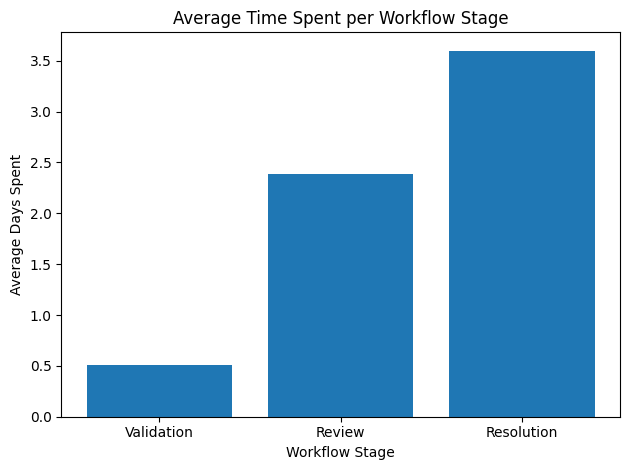

In [49]:
plt.figure()
plt.bar(time_summary['Stage'], time_summary['AvgDays'])
plt.xlabel('Workflow Stage')
plt.ylabel('Average Days Spent')
plt.title('Average Time Spent per Workflow Stage')
plt.tight_layout()
plt.show()


## Intake Source Impact

It's possible that certain intake channels introduce different levels of operational complexity.

This analysis breaks down resolution time by ticket source to understand whether structured intake methods outperform unstructured ones and where upstream improvements may yield downstream efficiency gains.

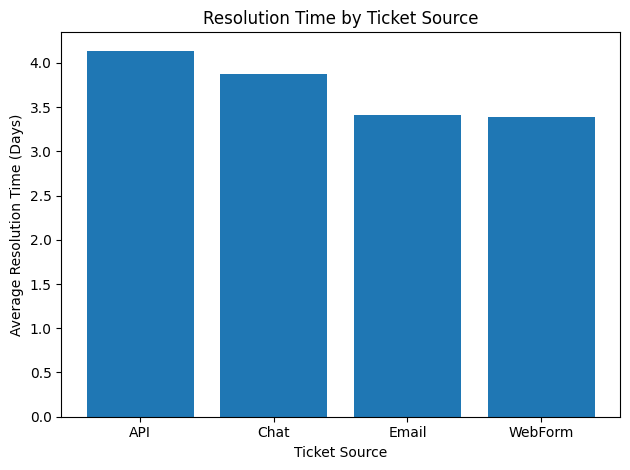

In [50]:
source_time = (
    tickets
    .groupby('Source')['ResolutionTimeDays']
    .mean()
    .reset_index()
    .sort_values('ResolutionTimeDays', ascending=False)
)

plt.figure()
plt.bar(source_time['Source'], source_time['ResolutionTimeDays'])
plt.xlabel('Ticket Source')
plt.ylabel('Average Resolution Time (Days)')
plt.title('Resolution Time by Ticket Source')
plt.tight_layout()
plt.show()


## Key Findings & Operational Recommendations

### Key Findings
- The largest workflow bottleneck occurs during the Resolution stage.
- Resolution time significantly exceeds time spent in validation and review.
- Tickets originating from unstructured intake channels take longer to resolve.

### Recommendations
- Invest in automation or tooling that reduces resolution-stage handoffs.
- Encourage structured intake methods to improve downstream efficiency.
- Monitor resolution cycle time as a leading indicator of operational health.

